# Part I - Introduction and Data Description

For this demonstration, we will use a bank marketing data set. A bank ran a marketing campaign in the past and has obtained data pertaining to nearly 45,000 customers, which includes variables such as their age, jobs, bank balance, education, loan status and so on. Based on this data, the bank wants to develop its future strategies based on the insights that it drew from the previous campaign and improve for the next campaign so that more customers agree to open term deposits with the bank.

Here, `'y'` (whether the customer wishes to open a deposit or not) is the target variable. A `'Yes'` in the `'y'` column indicates that the campaign was successful and the customer agreed to open a term deposit account with the bank. In contrast, a `'No'` in the `'y'` column indicates that the campaign was not very successful and the customer could not be convinced to open a term deposit account.

The purpose of this demonstration is to show the viewer how to build and implement random forest models and gradient boosted tree models for classification. We will also look at how model performance varies for different values of various hyperparameters.

## Data description

### Input features
- ***age*** : Age of the customer (numeric)
- ***job*** : Type of job (categorical)
- ***marital*** : Marital status (categorical)
- ***education***: Level of education (categorical)
- ***default***: Does the customer have a credit default or not? (categorical: 'no', 'yes', 'unknown')
- ***balance***: Bank balance of the customer (numeric)
- ***housing***: Does the customer have a housing loan or not? (categorical: 'no', 'yes', 'unknown')
- ***loan***: Does the customer have a personal loan or not? (categorical: 'no', 'yes', 'unknown')
- ***contact***: Contact communication type (categorical)
- ***day***: Last contact day of the week (categorical)
- ***month***: Last contact month of year (categorical)
- ***duration***: Last contact duration, in seconds (numeric)
- ***campaign***: Number of contacts performed during this campaign and for this client (numeric, includes last contact)
- ***pdays***: Number of days that passed by after the client was last contacted from a previous campaign (numeric)
- ***previous***: Number of contacts performed before this campaign and for this client (numeric)
- ***poutcome***: Outcome of the previous marketing campaign (categorical)

### Output feature
- ***y***: Has the client subscribed a term deposit? (categorical: 'yes', 'no')

In [ ]:
# !pip install lightgbm  # Run this cell to install the lightgbm library

In [1]:
# Importing 'numpy' and 'pandas' packages for working with numbers and data frames
import numpy as np
import pandas as pd

# Importing 'matplotlib.pyplot' and 'seaborn' for visualisations
from matplotlib import pyplot as plt
import seaborn as sns

# Importing packages for building ensemble models
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier 

# Importing method for train-test split
from sklearn.model_selection import train_test_split

# Importing sutiable error measure methods
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, roc_auc_score

# Import 'GridSearchCV' for hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Ignore warnings to keep output clean
import warnings
warnings.filterwarnings('ignore')

In [3]:
import yaml

# Load the environment.yml file
with open("../configs/environment.yml", "r") as f:
    config = yaml.safe_load(f)

# Choose environment (local or aws)
env = "local"   # or "aws"

base_path = config[env]["base_path"]
raw_data_path = base_path + config[env]["raw_data"]
processed_data_path = base_path + config[env]["processed_data"]
models_path = base_path + config[env]["models"]

print("Raw data path:", raw_data_path)
print("Processed data path:", processed_data_path)
print("Models path:", models_path)


Raw data path: /Users/aditikulkarni/Documents/Masters/AI-Projects/04-ML-Models/ensembles-bagging-boosting/data/raw/
Processed data path: /Users/aditikulkarni/Documents/Masters/AI-Projects/04-ML-Models/ensembles-bagging-boosting/data/processed/
Models path: /Users/aditikulkarni/Documents/Masters/AI-Projects/04-ML-Models/ensembles-bagging-boosting/models/


In [5]:
# Importing the raw data
file_path = raw_data_path + 'bank-full.csv'
df = pd.read_csv(file_path, delimiter = ';')  # This dataset uses semicolons instead of commas to separate values

In [6]:
# Taking a look at a sample of the data
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
# Discard features not used in this analysis
df = df[['age', 'duration', 'balance', 'job', 'marital', 'education', 'y']]

In [8]:
# Generating dummy variables for categorical features
df_dummies = pd.get_dummies(df, columns = ['job', 'marital', 'education', 'y'])
df_dummies.head()

,age,duration,balance,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,y_no,y_yes
0,58,261,2143,False,False,False,False,True,False,False,...,False,False,True,False,False,False,True,False,True,False
1,44,151,29,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,True,False
2,33,76,2,False,False,True,False,False,False,False,...,False,False,True,False,False,True,False,False,True,False
3,47,92,1506,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,True,False
4,33,198,1,False,False,False,False,False,False,False,...,True,False,False,True,False,False,False,True,True,False


In [10]:
# Taking a look at the new dummy variables
for col in df_dummies.columns:
    print(col)

age
duration
balance
job_admin.
job_blue-collar
job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_technician
job_unemployed
job_unknown
marital_divorced
marital_married
marital_single
education_primary
education_secondary
education_tertiary
education_unknown
y_no
y_yes


In [14]:
# Splitting the data into input (select features) and output
df_dummies = df_dummies[['age', 'duration', 'balance', 
                         'job_services', 'job_management', 'job_student', 'job_retired', 
                         'marital_divorced', 'marital_married', 'marital_single', 
                         'education_primary', 'education_secondary', 'education_tertiary', 
                         'y_yes']]

In [15]:
X = df_dummies.drop('y_yes', axis = 1)
y = df_dummies['y_yes']

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 123)

# Part 2 - Random Forest

In [18]:
# Creating a random forest classifier
# Use 100 estimators, a maximum tree depth of 5, and set the class weight as 'balanced'
# Set the random state parameter to 123
rf = RandomForestClassifier(n_estimators = 100, max_depth = 5, class_weight = 'balanced', random_state = 123)

# Fit the model to the training data
rf.fit(X_train, y_train);

In [19]:
# Obtaining the feature importances from the model
rfimp = rf.feature_importances_
rfimp

array([0.10769608, 0.70081451, 0.06884448, 0.00170472, 0.00372099,
       0.01987601, 0.01758014, 0.00145257, 0.01037305, 0.02183268,
       0.00915411, 0.004754  , 0.03219668])

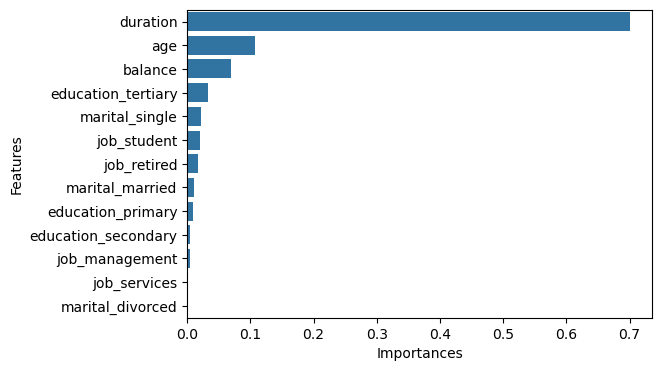

In [20]:
plt.figure(figsize = (6, 4))
rfimpdf = pd.DataFrame(data = {'Features': X_train.columns, 'Importances': rfimp})
rfimpdf = rfimpdf.sort_values(by = 'Importances', ascending = False)
sns.barplot(data = rfimpdf, x = 'Importances', y = 'Features', orient = 'h');

As you can see from the above graph, ***duration*** has been determined as the most important feature by the random forest model.

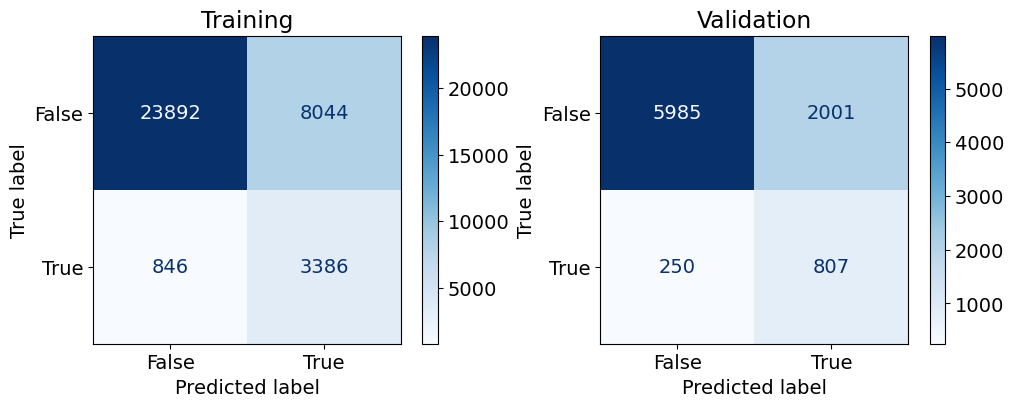

In [21]:
# Display the confusion matrices for the model on the training and validation data
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ConfusionMatrixDisplay.from_estimator(rf, X_train, y_train, cmap = plt.cm.Blues, ax = ax[0])
ConfusionMatrixDisplay.from_estimator(rf, X_val, y_val, cmap = plt.cm.Blues, ax = ax[1])
ax[0].set_title('Training')
ax[1].set_title('Validation');

In [22]:
# Obtaining predictions on the training and testing sets
y_pred_train = rf.predict(X_train)
y_pred_val = rf.predict(X_val)

# Compute accuracy scores
train_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)

print('Accuracy on the training data = {}'.format(train_acc))
print('Accuracy on the validation data = {}'.format(val_acc))

Accuracy on the training data = 0.7542026100420262
Accuracy on the validation data = 0.7510781820192414


In [23]:
# Compute the ROC AUC scores for the training and the validation data
# Obtain predicted probabilities for class '1'
train_probabilities = rf.predict_proba(X_train)[:, 1]
val_probabilities = rf.predict_proba(X_val)[:, 1]

# Compute ROC AUC scores
train_auc = roc_auc_score(y_train, train_probabilities)
val_auc = roc_auc_score(y_val, val_probabilities)

print('ROC AUC score for the training data = {}'.format(train_auc))
print('ROC AUC score for the validation data = {}'.format(val_auc))

ROC AUC score for the training data = 0.8504589038367377
ROC AUC score for the validation data = 0.835218491394946


# Part 3 - Random Forest: Hyperparameter Tuning

In this section, we will:
- Tune the random forest model for the following hyperparameters:
  - Number of estimators
  - Maximum tree depth
- Tune the random forest model for a combination of number of estimators and maximum tree depth

## Subpart 1 - Hyperparameter Tuning: Number of Estimators

In [24]:
# Define a list of number of estimators to tune over
num_estimators = np.arange(50, 550, 50) # This creates a list of values from 50 to 500 with an increment of 50

# Create and train a random forest model for each performance value of number of estimators
performance_df = pd.DataFrame(data = None)

# Use a for loop to loop over the different models and capture their performances
indexcount = -1
for current_num_estimators in num_estimators:
    indexcount = indexcount + 1

    # Create a random forest model with the current specifications
    # Use the current number of estimators, a maximum tree depth of 5, and set the class weight as 'balanced'
    # Set the random state parameter to 123
    current_rf = RandomForestClassifier(n_estimators = current_num_estimators,
                                        max_depth = 5,
                                        class_weight = 'balanced',
                                        random_state = 123)

    # Fit the model on the training data
    current_rf.fit(X_train, y_train)

    print('\n Training for {} estimators is complete'.format(current_num_estimators))

    # Obtain predictions
    current_y_pred_train = current_rf.predict(X_train)
    current_y_pred_val = current_rf.predict(X_val)

    # Compute accuracy scores
    current_train_acc = accuracy_score(y_train, current_y_pred_train)
    current_val_acc = accuracy_score(y_val, current_y_pred_val)

    # Obtain predicted probabilities for class '1'
    current_train_probabilities = current_rf.predict_proba(X_train)[:, 1]
    current_val_probabilities = current_rf.predict_proba(X_val)[:, 1]

    # Compute ROC AUC scores
    current_train_auc = roc_auc_score(y_train, current_train_probabilities)
    current_val_auc = roc_auc_score(y_val, current_val_probabilities)

    tempdf = pd.DataFrame(index = [indexcount],
                          data = {'Number of Estimators': current_num_estimators,
                                  'Training Accuracy': current_train_acc,
                                  'Validation Accuracy': current_val_acc,
                                  'Training ROC AUC': current_train_auc,
                                  'Validation ROC AUC': current_val_auc})

    performance_df = pd.concat([performance_df, tempdf])

performance_df.set_index('Number of Estimators')


 Training for 50 estimators is complete

 Training for 100 estimators is complete

 Training for 150 estimators is complete

 Training for 200 estimators is complete

 Training for 250 estimators is complete

 Training for 300 estimators is complete

 Training for 350 estimators is complete

 Training for 400 estimators is complete

 Training for 450 estimators is complete

 Training for 500 estimators is complete


,Training Accuracy,Validation Accuracy,Training ROC AUC,Validation ROC AUC
Number of Estimators,,,,
50,0.742562,0.739135,0.850477,0.835397
100,0.754203,0.751078,0.850459,0.835218
150,0.753567,0.750083,0.851327,0.835697
200,0.758682,0.756386,0.852480,0.837417
250,0.755281,0.751410,0.852069,0.836802
300,0.755751,0.752405,0.852363,0.837284
350,0.755419,0.752405,0.852350,0.837261
400,0.755696,0.752737,0.852030,0.836720
450,0.756166,0.753511,0.852235,0.837144


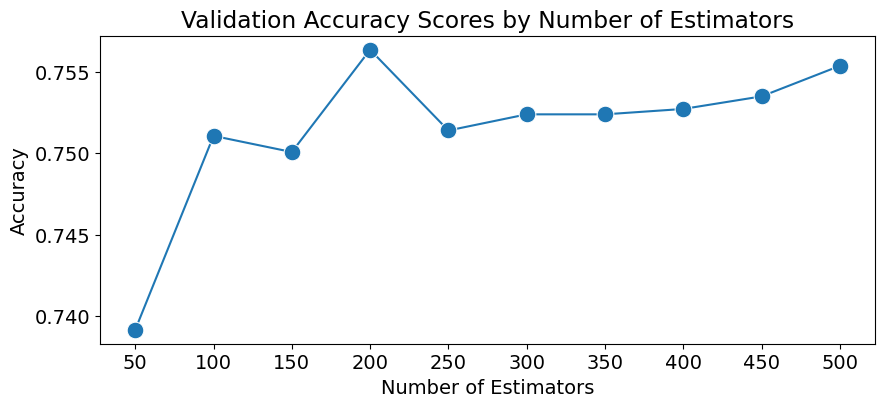

In [25]:
# Visualise variation in validation accuracy scores with respect to number of estimators
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Number of Estimators', y = 'Validation Accuracy', marker = 'o', markersize = 12)
plt.title('Validation Accuracy Scores by Number of Estimators')
plt.ylabel('Accuracy')
plt.xlabel('Number of Estimators')
plt.xticks(num_estimators);

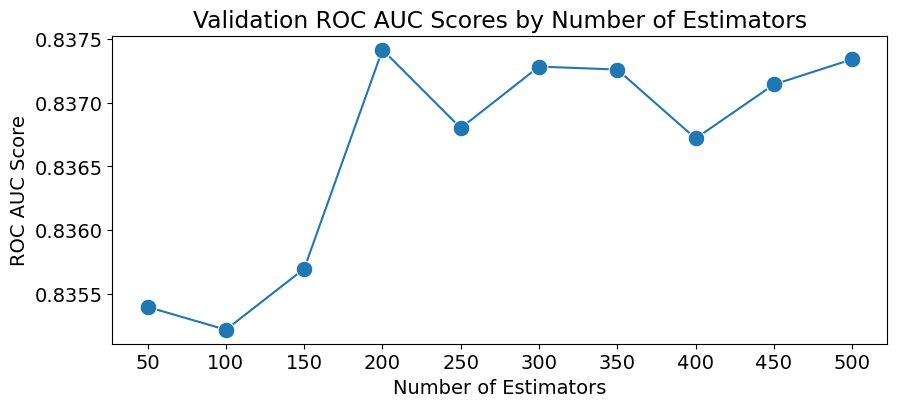

In [26]:
# Visualise variation in validation accuracy scores with respect to number of estimators
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Number of Estimators', y = 'Validation ROC AUC', marker = 'o', markersize = 12)
plt.title('Validation ROC AUC Scores by Number of Estimators')
plt.ylabel('ROC AUC Score')
plt.xlabel('Number of Estimators')
plt.xticks(num_estimators);

## Subpart 2 - Hyperparameter Tuning: Maximum Tree Depth

In [27]:
# Define a list of maximum tree depths to tune over
max_tree_depths = np.arange(1, 11, 1)

# Create and train a random forest model for each value of maximum tree depth
performance_df = pd.DataFrame(data = None)

# Use a for loop to loop over the different models and capture their performances
indexcount = -1
for current_max_tree_depth in max_tree_depths:
    indexcount = indexcount + 1

    # Create a random forest model with the current specifications
    # Use 200 estimators, the current maximum tree depth, and set the class weight as 'balanced'
    # Set the random state parameter to 123
    current_rf = RandomForestClassifier(n_estimators = 200,
                                        max_depth = current_max_tree_depth,
                                        class_weight = 'balanced',
                                        random_state = 123)

    # Fit the model on the training data
    current_rf.fit(X_train, y_train)

    print('\n Training for tree depth of {} is complete'.format(current_max_tree_depth))

    # Obtain predictions
    current_y_pred_train = current_rf.predict(X_train)
    current_y_pred_val = current_rf.predict(X_val)

    # Compute accuracy scores
    current_train_acc = accuracy_score(y_train, current_y_pred_train)
    current_val_acc = accuracy_score(y_val, current_y_pred_val)

    # Obtain predicted probabilities for class '1'
    current_train_probabilities = current_rf.predict_proba(X_train)[:, 1]
    current_val_probabilities = current_rf.predict_proba(X_val)[:, 1]

    # Compute ROC AUC scores
    current_train_auc = roc_auc_score(y_train, current_train_probabilities)
    current_val_auc = roc_auc_score(y_val, current_val_probabilities)

    tempdf = pd.DataFrame(index = [indexcount],
                          data = {'Maximum Tree Depth': current_max_tree_depth,
                                  'Training Accuracy': current_train_acc,
                                  'Validation Accuracy': current_val_acc,
                                  'Training ROC AUC': current_train_auc,
                                  'Validation ROC AUC': current_val_auc})

    performance_df = pd.concat([performance_df, tempdf])

performance_df.set_index('Maximum Tree Depth')


 Training for tree depth of 1 is complete

 Training for tree depth of 2 is complete

 Training for tree depth of 3 is complete

 Training for tree depth of 4 is complete

 Training for tree depth of 5 is complete

 Training for tree depth of 6 is complete

 Training for tree depth of 7 is complete

 Training for tree depth of 8 is complete

 Training for tree depth of 9 is complete

 Training for tree depth of 10 is complete


,Training Accuracy,Validation Accuracy,Training ROC AUC,Validation ROC AUC
Maximum Tree Depth,,,,
1,0.646455,0.647130,0.795961,0.783374
2,0.690832,0.688157,0.827972,0.816284
3,0.713614,0.709720,0.835659,0.823174
4,0.736314,0.734380,0.844811,0.831897
5,0.758682,0.756386,0.852480,0.837417
6,0.769299,0.763685,0.859491,0.841583
7,0.777013,0.772310,0.866294,0.842447
8,0.784340,0.777729,0.874345,0.843697
9,0.789621,0.780272,0.884751,0.843185


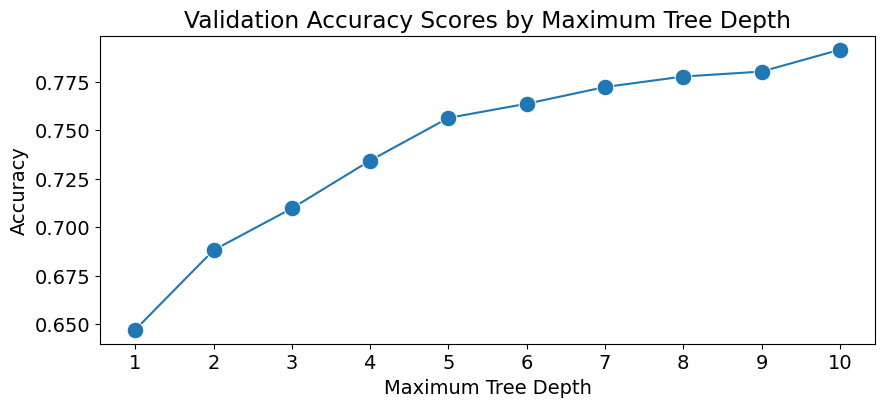

In [28]:
# Visualise variation in validation accuracy scores with respect to the maximum tree depth
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Maximum Tree Depth', y = 'Validation Accuracy', marker = 'o', markersize = 12)
plt.title('Validation Accuracy Scores by Maximum Tree Depth')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.xticks(max_tree_depths);

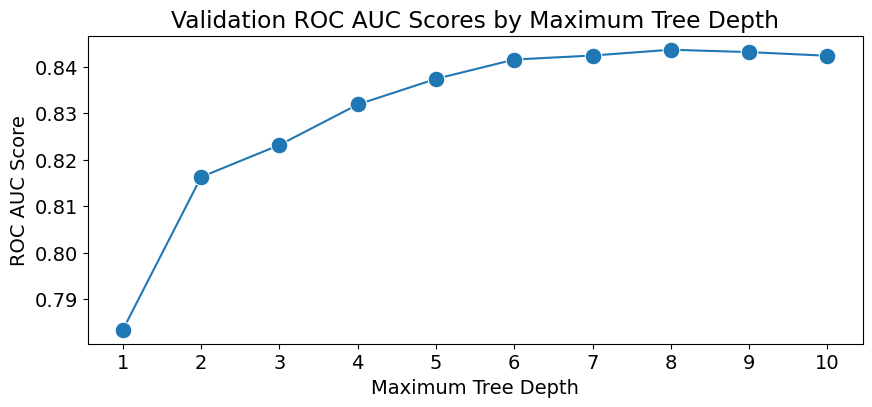

In [29]:
# Visualise variation in validation ROC AUC scores with respect to the maximum tree depth
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Maximum Tree Depth', y = 'Validation ROC AUC', marker = 'o', markersize = 12)
plt.title('Validation ROC AUC Scores by Maximum Tree Depth')
plt.ylabel('ROC AUC Score')
plt.xlabel('Maximum Tree Depth')
plt.xticks(max_tree_depths);

## Subpart 3 - Hyperparameter Tuning: Combination of Hyperparameters

In [30]:
# Initialise a basic random forest classifier model
# Set the class weight as 'balanced'
# Set the random state parameter to 123
base_grid_model = RandomForestClassifier(class_weight = 'balanced', random_state = 123)

# Define a range of hyperparameter values to tune for and store them in a dictionary
parameters_grid = {'n_estimators': [100, 200, 500],
                   'max_depth': [5, 6, 7, 8]}

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
# Use ROC AUC score as a scoring metric
# Use the default number of cross-validation folds
# Set the 'verbose' parameter to 3 or more to display useful results during the process
grid = GridSearchCV(estimator = base_grid_model,
                    param_grid = parameters_grid,
                    scoring = 'roc_auc',
                    verbose = 4)

# Fit the model on the training data
grid_model = grid.fit(X_train, y_train)

# Print the optimal values of 'n_estimators' and 'max_depth'
best_n_estimators = grid_model.best_params_['n_estimators']
best_max_depth = grid_model.best_params_['max_depth']
best_roc_auc_score = grid_model.best_score_

print('\n The optimal model has {} estimators, each of maximum tree depth {}, and it has an ROC AUC score of {}.'.format(best_n_estimators, best_max_depth, best_roc_auc_score))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .....max_depth=5, n_estimators=100;, score=0.835 total time=   0.5s
[CV 2/5] END .....max_depth=5, n_estimators=100;, score=0.841 total time=   0.5s
[CV 3/5] END .....max_depth=5, n_estimators=100;, score=0.852 total time=   0.5s
[CV 4/5] END .....max_depth=5, n_estimators=100;, score=0.836 total time=   0.5s
[CV 5/5] END .....max_depth=5, n_estimators=100;, score=0.854 total time=   0.5s
[CV 1/5] END .....max_depth=5, n_estimators=200;, score=0.836 total time=   1.0s
[CV 2/5] END .....max_depth=5, n_estimators=200;, score=0.841 total time=   1.0s
[CV 3/5] END .....max_depth=5, n_estimators=200;, score=0.853 total time=   1.0s
[CV 4/5] END .....max_depth=5, n_estimators=200;, score=0.837 total time=   1.0s
[CV 5/5] END .....max_depth=5, n_estimators=200;, score=0.855 total time=   1.0s
[CV 1/5] END .....max_depth=5, n_estimators=500;, score=0.838 total time=   2.4s
[CV 2/5] END .....max_depth=5, n_estimators=500;

# Part 4 - Gradient Boosted Tree

We will now fit a gradient boosted tree model to the data and study the performance of the model on the training and validation data.

In [31]:
# Create a gradient boosted tree classifier model
# Use 100 estimators, a maximum tree depth of 5, a learning rate of 0.1, and set the class weight as 'balanced'
# Set the random state parameter to 123
gbt = LGBMClassifier(n_estimators = 100, max_depth = 5, learning_rate = 0.1, class_weight = 'balanced', random_state = 123, verbose = -1)

# Fit the model to the training data
gbt.fit(X_train, y_train);

In [32]:
# Obtaining the feature importances from the model
gbtimp = gbt.feature_importances_
gbtimp

array([600, 759, 721,  26,  39,  48,  10,  43,  73,  57,  70,  36,  82],
      dtype=int32)

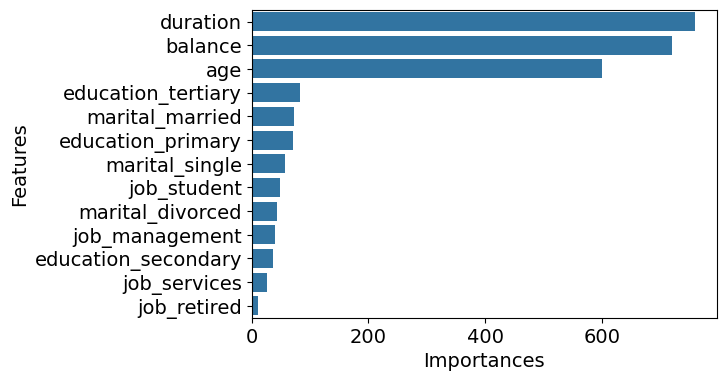

In [33]:
# Visualising the feature importances
plt.figure(figsize = (6, 4))
gbtimpdf = pd.DataFrame(data = {'Features': X_train.columns, 'Importances': gbtimp})
gbtimpdf = gbtimpdf.sort_values(by = 'Importances', ascending = False)
sns.barplot(data = gbtimpdf, x = 'Importances', y = 'Features', orient = 'h');

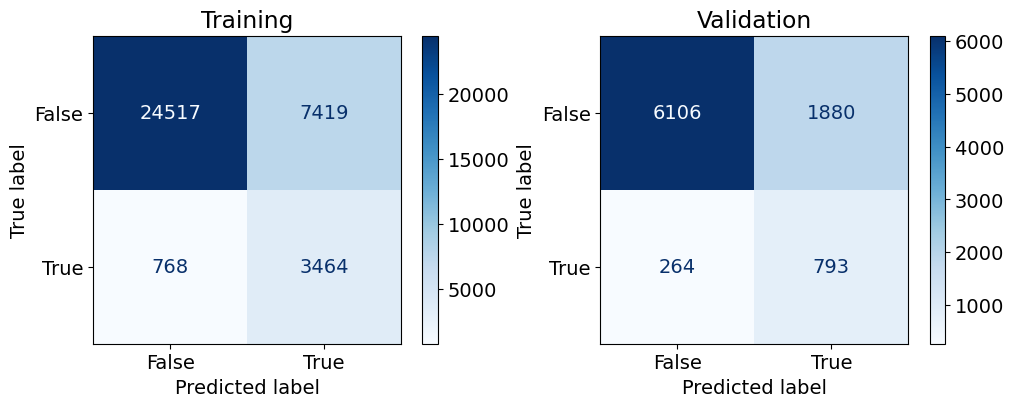

In [34]:
# Display the confusion matrices for the model on the training and validation data
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
ConfusionMatrixDisplay.from_estimator(gbt, X_train, y_train, cmap = plt.cm.Blues, ax = ax[0])
ConfusionMatrixDisplay.from_estimator(gbt, X_val, y_val, cmap = plt.cm.Blues, ax = ax[1])
ax[0].set_title('Training')
ax[1].set_title('Validation');

In [35]:
# Compute the accuracy scores on the training and validation data
# Obtaining predictions
y_pred_train = gbt.predict(X_train)
y_pred_val = gbt.predict(X_val)

# Compute accuracy scores
train_acc = accuracy_score(y_train, y_pred_train)
val_acc = accuracy_score(y_val, y_pred_val)

print('Accuracy on the training data = {}'.format(train_acc))
print('Accuracy on the validation data = {}'.format(val_acc))

Accuracy on the training data = 0.7736396814863968
Accuracy on the validation data = 0.7629105385380958


In [36]:
# Compute the ROC AUC scores for the training and validation data
# Obtaining predicted probabilities for class '1'
train_probabilities = gbt.predict_proba(X_train)[:, 1]
val_probabilities = gbt.predict_proba(X_val)[:, 1]

# Compute ROC AUC scores
train_auc = roc_auc_score(y_train, train_probabilities)
val_auc = roc_auc_score(y_val, val_probabilities)

print('ROC AUC score for the training data = {}'.format(train_auc))
print('ROC AUC score for the validation data = {}'.format(val_auc))

ROC AUC score for the training data = 0.8796725769296154
ROC AUC score for the validation data = 0.8456259546922347


# Part 5 - Gradient Boosted Tree: Hyperparameter Tuning

In this section, we will:
- Tune the gradient boosted tree model for the following hyperparameters:
  - Number of estimators
  - Maximum tree depth
  - Learning rate
- Tune the gradient boosted tree model for a combination of the number of estimators, maximum tree depth, and learning rate

## Subpart 1 - Hyperparameter Tuning: Number of Estimators

In [37]:
# Define a list of number of estimators to tune over
num_estimators = np.arange(50, 550, 50)

# Create and train a gradient boosted tree for each value of number of estimators
performance_df = pd.DataFrame(data = None)

# Use a for loop to loop over the different models and capture their performances
indexcount = -1
for current_num_estimators in num_estimators:
    indexcount = indexcount + 1

    # Create a gradient boosted tree model with the current specifications
    # Use the current number of estimators, a maximum tree depth of 5, a learning rate of 0.1, and set the class weight as 'balanced'
    # Set the random state parameter to 123
    current_gbt = LGBMClassifier(n_estimators = current_num_estimators,
                                 max_depth = 5,
                                 learning_rate = 0.1,
                                 class_weight = 'balanced',
                                 random_state = 123)

    # Fit the model on the training data
    current_gbt.fit(X_train, y_train)

    print('\n Training for {} estimators is complete'.format(current_num_estimators))

    # Obtain predictions
    current_y_pred_train = current_gbt.predict(X_train)
    current_y_pred_val = current_gbt.predict(X_val)

    # Compute accuracy scores
    current_train_acc = accuracy_score(y_train, current_y_pred_train)
    current_val_acc = accuracy_score(y_val, current_y_pred_val)

    # Obtain predicted probabilities for class '1'
    current_train_probabilities = current_gbt.predict_proba(X_train)[:, 1]
    current_val_probabilities = current_gbt.predict_proba(X_val)[:, 1]

    # Compute ROC AUC scores
    current_train_auc = roc_auc_score(y_train, current_train_probabilities)
    current_val_auc = roc_auc_score(y_val, current_val_probabilities)

    tempdf = pd.DataFrame(index = [indexcount],
                          data = {'Number of Estimators': current_num_estimators,
                                  'Training Accuracy': current_train_acc,
                                  'Validation Accuracy': current_val_acc,
                                  'Training ROC AUC': current_train_auc,
                                  'Validation ROC AUC': current_val_auc})

    performance_df = pd.concat([performance_df, tempdf])

performance_df.set_index('Number of Estimators')


 Training for 50 estimators is complete

 Training for 100 estimators is complete

 Training for 150 estimators is complete

 Training for 200 estimators is complete

 Training for 250 estimators is complete

 Training for 300 estimators is complete

 Training for 350 estimators is complete

 Training for 400 estimators is complete

 Training for 450 estimators is complete

 Training for 500 estimators is complete


,Training Accuracy,Validation Accuracy,Training ROC AUC,Validation ROC AUC
Number of Estimators,,,,
50,0.767059,0.759814,0.869618,0.846385
100,0.773640,0.762911,0.879673,0.845626
150,0.782598,0.767555,0.889683,0.844722
200,0.791169,0.771978,0.898305,0.844592
250,0.799630,0.777729,0.906275,0.843463
300,0.805712,0.780714,0.912555,0.842121
350,0.811629,0.782152,0.918325,0.841023
400,0.816274,0.784142,0.923142,0.840520
450,0.820753,0.788013,0.928234,0.839613


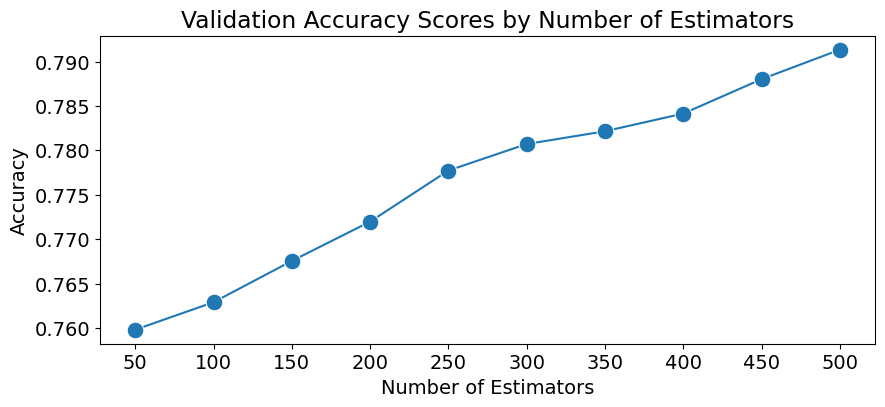

In [38]:
# Visualise variation in validation accuracy scores with respect to number of estimators
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Number of Estimators', y = 'Validation Accuracy', marker = 'o', markersize = 12)
plt.title('Validation Accuracy Scores by Number of Estimators')
plt.ylabel('Accuracy')
plt.xlabel('Number of Estimators')
plt.xticks(num_estimators);

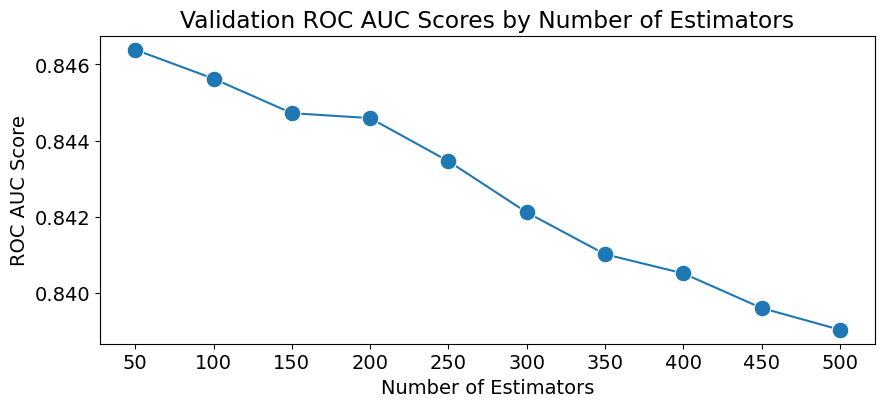

In [39]:
# Visualise variation in validation accuracy scores with respect to number of estimators
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Number of Estimators', y = 'Validation ROC AUC', marker = 'o', markersize = 12)
plt.title('Validation ROC AUC Scores by Number of Estimators')
plt.ylabel('ROC AUC Score')
plt.xlabel('Number of Estimators')
plt.xticks(num_estimators);

## Subpart 2 - Hyperparameter Tuning: Maximum Tree Depth

In [40]:
# Define a list of maximum tree depths to tune over
max_tree_depths = np.arange(1, 11, 1)

# Create and train a gradient boosted tree model for each value of maximum tree depth
performance_df = pd.DataFrame(data = None)

# Use a for loop to loop over the different models and capture their performances
indexcount = -1
for current_max_tree_depth in max_tree_depths:
    indexcount = indexcount + 1

    # Create a gradient boosted tree with the current specifications
    # Use 100 estimators, the current maximum tree depth, a learning rate of 0.1, and set the class weight as 'balanced'
    # Set the random state parameter to 123
    current_gbt = LGBMClassifier(n_estimators = 100,
                                 max_depth = current_max_tree_depth,
                                 learning_rate = 0.1,
                                 class_weight = 'balanced',
                                 random_state = 123)

    # Fit the model on the training data
    current_gbt.fit(X_train, y_train)

    print('\n Training for tree depth of {} is complete'.format(current_max_tree_depth))

    # Obtain predictions
    current_y_pred_train = current_gbt.predict(X_train)
    current_y_pred_val = current_gbt.predict(X_val)

    # Compute accuracy scores
    current_train_acc = accuracy_score(y_train, current_y_pred_train)
    current_val_acc = accuracy_score(y_val, current_y_pred_val)

    # Obtain predicted probabilities for class '1'
    current_train_probabilities = current_gbt.predict_proba(X_train)[:, 1]
    current_val_probabilities = current_gbt.predict_proba(X_val)[:, 1]

    # Compute ROC AUC scores
    current_train_auc = roc_auc_score(y_train, current_train_probabilities)
    current_val_auc = roc_auc_score(y_val, current_val_probabilities)

    tempdf = pd.DataFrame(index = [indexcount],
                          data = {'Maximum Tree Depth': current_max_tree_depth,
                                  'Training Accuracy': current_train_acc,
                                  'Validation Accuracy': current_val_acc,
                                  'Training ROC AUC': current_train_auc,
                                  'Validation ROC AUC': current_val_auc})

    performance_df = pd.concat([performance_df, tempdf])

performance_df.set_index('Maximum Tree Depth')


 Training for tree depth of 1 is complete

 Training for tree depth of 2 is complete

 Training for tree depth of 3 is complete

 Training for tree depth of 4 is complete

 Training for tree depth of 5 is complete

 Training for tree depth of 6 is complete

 Training for tree depth of 7 is complete

 Training for tree depth of 8 is complete

 Training for tree depth of 9 is complete

 Training for tree depth of 10 is complete


,Training Accuracy,Validation Accuracy,Training ROC AUC,Validation ROC AUC
Maximum Tree Depth,,,,
1,0.762276,0.760699,0.848993,0.839322
2,0.765262,0.764901,0.857720,0.845571
3,0.765207,0.759593,0.863475,0.847012
4,0.767225,0.760146,0.870621,0.845984
5,0.773640,0.762911,0.879673,0.845626
6,0.780497,0.767444,0.887670,0.845867
7,0.785722,0.768771,0.890738,0.844223
8,0.787049,0.770209,0.893103,0.845551
9,0.786220,0.769103,0.895171,0.843961


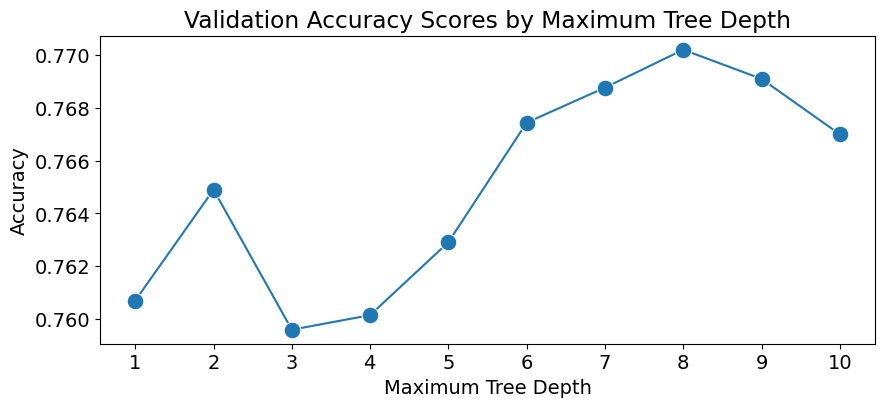

In [41]:
# Visualise variation in validation accuracy scores with respect to the maximum tree depth
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Maximum Tree Depth', y = 'Validation Accuracy', marker = 'o', markersize = 12)
plt.title('Validation Accuracy Scores by Maximum Tree Depth')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Tree Depth')
plt.xticks(max_tree_depths);

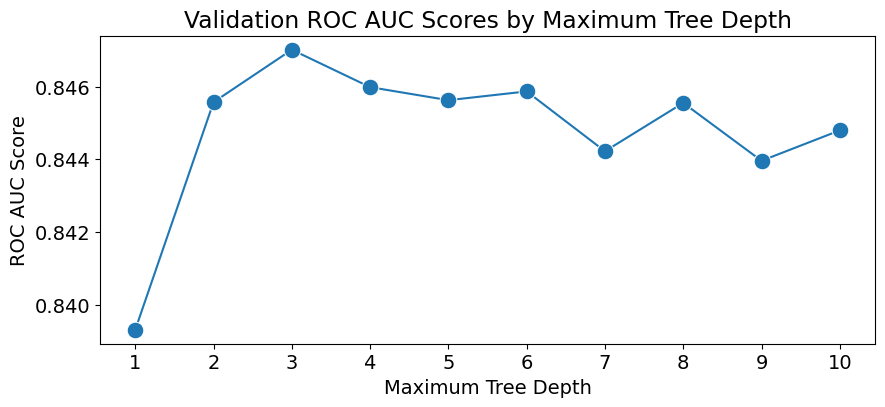

In [42]:
# Visualise variation in validation ROC AUC scores with respect to the maximum tree depth
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Maximum Tree Depth', y = 'Validation ROC AUC', marker = 'o', markersize = 12)
plt.title('Validation ROC AUC Scores by Maximum Tree Depth')
plt.ylabel('ROC AUC Score')
plt.xlabel('Maximum Tree Depth')
plt.xticks(max_tree_depths);

## Subpart 3 - Hyperparameter Tuning: Learning Rate

In [43]:
# Define a list of learning rates to tune over
learning_rates = np.arange(0.02, 0.22, 0.02)

# Create and train a gradient boosted tree model for each value of learning rate
performance_df = pd.DataFrame(data = None)

# Use a for loop to loop over the different models and capture their performances
indexcount = -1
for current_learning_rate in learning_rates:
    indexcount = indexcount + 1

    # Create a gradient boosted tree with the current specifications
    # Use 100 estimators, a maximum tree depth of 5, the current learning rate, and set the class weight as 'balanced'
    # Set the random state parameter to 123
    current_gbt = LGBMClassifier(n_estimators = 100,
                                 max_depth = 5,
                                 learning_rate = current_learning_rate,
                                 class_weight = 'balanced',
                                 random_state = 123)

    # Fit the model on the training data
    current_gbt.fit(X_train, y_train)

    print('\n Training for learning rate of {} is complete'.format(np.round(current_learning_rate, 2)))

    # Obtain predictions
    current_y_pred_train = current_gbt.predict(X_train)
    current_y_pred_val = current_gbt.predict(X_val)

    # Compute accuracy scores
    current_train_acc = accuracy_score(y_train, current_y_pred_train)
    current_val_acc = accuracy_score(y_val, current_y_pred_val)

    # Obtain predicted probabilities for class '1'
    current_train_probabilities = current_gbt.predict_proba(X_train)[:, 1]
    current_val_probabilities = current_gbt.predict_proba(X_val)[:, 1]

    # Compute ROC AUC scores
    current_train_auc = roc_auc_score(y_train, current_train_probabilities)
    current_val_auc = roc_auc_score(y_val, current_val_probabilities)

    tempdf = pd.DataFrame(index = [indexcount],
                          data = {'Learning Rate': current_learning_rate,
                                  'Training Accuracy': current_train_acc,
                                  'Validation Accuracy': current_val_acc,
                                  'Training ROC AUC': current_train_auc,
                                  'Validation ROC AUC': current_val_auc})

    performance_df = pd.concat([performance_df, tempdf])

performance_df.set_index('Learning Rate')


 Training for learning rate of 0.02 is complete

 Training for learning rate of 0.04 is complete

 Training for learning rate of 0.06 is complete

 Training for learning rate of 0.08 is complete

 Training for learning rate of 0.1 is complete

 Training for learning rate of 0.12 is complete

 Training for learning rate of 0.14 is complete

 Training for learning rate of 0.16 is complete

 Training for learning rate of 0.18 is complete

 Training for learning rate of 0.2 is complete


,Training Accuracy,Validation Accuracy,Training ROC AUC,Validation ROC AUC
Learning Rate,,,,
0.02,0.765787,0.761031,0.861098,0.844563
0.04,0.765870,0.758487,0.867035,0.846399
0.06,0.768331,0.759704,0.871940,0.846229
0.08,0.771760,0.762026,0.875089,0.845787
0.10,0.773640,0.762911,0.879673,0.845626
0.12,0.778782,0.763463,0.885317,0.845995
0.14,0.781547,0.767002,0.889195,0.845906
0.16,0.784699,0.767776,0.892026,0.844570
0.18,0.789123,0.771315,0.895836,0.843306


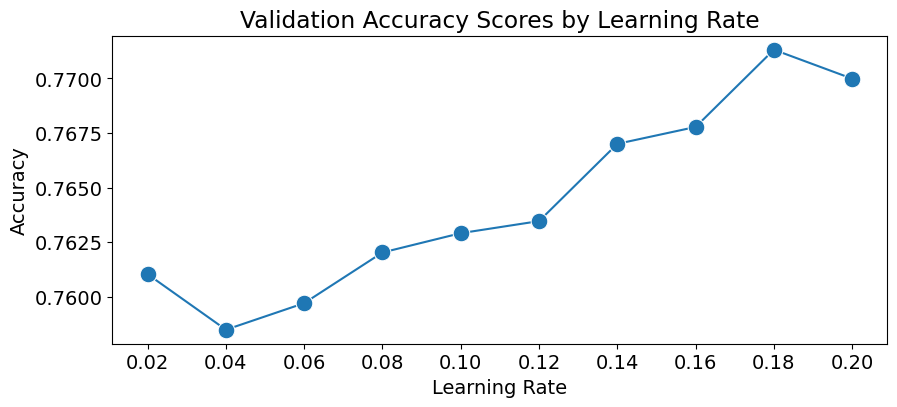

In [44]:
# Visualise variation in validation accuracy scores with respect to the learning rate
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Learning Rate', y = 'Validation Accuracy', marker = 'o', markersize = 12)
plt.title('Validation Accuracy Scores by Learning Rate')
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')
plt.xticks(learning_rates);

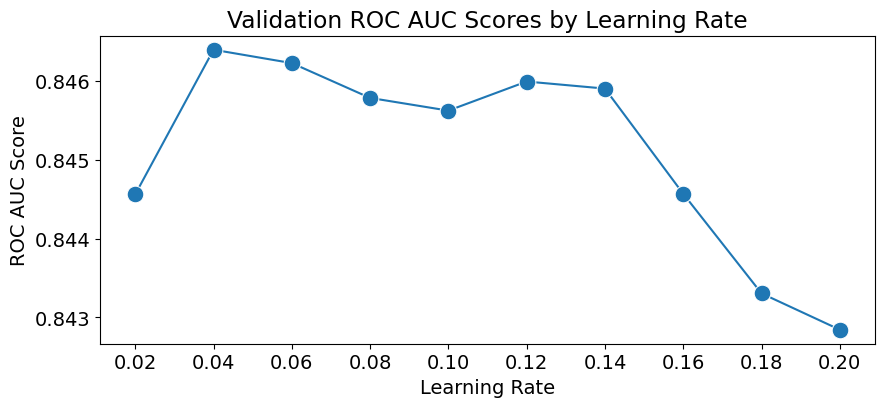

In [45]:
# Visualise variation in validation ROC AUC scores with respect to the learning rate
plt.figure(figsize = (10, 4))

sns.lineplot(data = performance_df, x = 'Learning Rate', y = 'Validation ROC AUC', marker = 'o', markersize = 12)
plt.title('Validation ROC AUC Scores by Learning Rate')
plt.ylabel('ROC AUC Score')
plt.xlabel('Learning Rate')
plt.xticks(learning_rates);

## Subpart 4 - Hyperparameter Tuning: Combinations of Hyperparameters

In [46]:
# Initialise a basic gradient boosted classifier model
# Set the class weight as 'balanced'
# Set the random state parameter to 123
base_grid_model = LGBMClassifier(class_weight = 'balanced', random_state = 123)

# Define a range of hyperparameter values to tune for and store them in a dictionary
parameters_grid = {'n_estimators': [400, 450],
                   'max_depth': [7, 8, 9],
                   'learning_rate': [0.06, 0.08]}

# Perform a grid search using the 'GridSearchCV()' method to obtain a grid on which to fit the training data
# Use ROC AUC score as a scoring metric
# Use the default number of cross-validation folds
# Set the 'verbose' parameter to 3 or more to display useful results during the process
grid = GridSearchCV(estimator = base_grid_model,
                    param_grid = parameters_grid,
                    scoring = 'roc_auc',
                    verbose = 4)

# Fit the model on the training data
grid_model = grid.fit(X_train, y_train)

# Print the optimal values of 'n_estimators' and 'max_depth'
best_n_estimators = grid_model.best_params_['n_estimators']
best_max_depth = grid_model.best_params_['max_depth']
best_learning_rate = grid_model.best_params_['learning_rate']
best_roc_auc_score = grid_model.best_score_

print('\n The optimal model has {} estimators, each of maximum tree depth {}, a learning rate of {}, and it has an ROC AUC score of {}.'.format(best_n_estimators, best_max_depth, best_learning_rate, best_roc_auc_score))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END learning_rate=0.06, max_depth=7, n_estimators=400;, score=0.840 total time=   1.4s
[CV 2/5] END learning_rate=0.06, max_depth=7, n_estimators=400;, score=0.841 total time=   1.4s
[CV 3/5] END learning_rate=0.06, max_depth=7, n_estimators=400;, score=0.848 total time=   1.4s
[CV 4/5] END learning_rate=0.06, max_depth=7, n_estimators=400;, score=0.843 total time=   1.3s
[CV 5/5] END learning_rate=0.06, max_depth=7, n_estimators=400;, score=0.858 total time=   1.2s
[CV 1/5] END learning_rate=0.06, max_depth=7, n_estimators=450;, score=0.839 total time=   1.6s
[CV 2/5] END learning_rate=0.06, max_depth=7, n_estimators=450;, score=0.840 total time=   1.5s
[CV 3/5] END learning_rate=0.06, max_depth=7, n_estimators=450;, score=0.847 total time=   1.5s
[CV 4/5] END learning_rate=0.06, max_depth=7, n_estimators=450;, score=0.843 total time=   1.6s
[CV 5/5] END learning_rate=0.06, max_depth=7, n_estimators=450;, score=0.85